In [ ]:
import pandas as pd
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from convokit import Corpus, Utterance, Speaker
import re

nltk.download('punkt')
nltk.download('stopwords')

In [ ]:
# Load the entire labelled dataset
df = pd.read_csv("data/entire_dataset_labeled_final.csv")
# Filter the rows with labels == 1
df = df[df['labels'] == 1]

# Extract week information from the 'created_at' column
df['created_at'] = pd.to_datetime(df['created_at'])
df['week'] = df['created_at'].dt.strftime('%Y-%U')

In [ ]:
french_stop_words = stopwords.words('french') + ["ca", "ça"]

In [ ]:
def tokenize_and_remove_stopwords(text, stop_words):
    # Tokenize using nltk's word_tokenize which handles punctuation well
    words = word_tokenize(text)

    # Initialize a list to hold filtered words
    # filtered_words = []

    # Iterate through the tokenized words
    # for i, word in enumerate(words):
    #     # Check if the token is a hashtag
    #     if word == '#':
    #         filtered_words.append(word)  # Keep the hashtag
    #     elif word.lower() not in stop_words and word.isalpha():
    #         if filtered_words and filtered_words[-1] == '#' and word.isalpha():
    #           # Combine the last word (hashtag) with the current word
    #           filtered_words[-1] = f"{filtered_words[-1]}{word}"  # No space added
    #         else:
    #           filtered_words.append(word)  # Keep non-stop word

    # Remove stop words and any standalone punctuation tokens
    filtered_words = [word for word in words if word.lower() not in stop_words and word.isalpha()]

    return " ".join(filtered_words)

# Apply the function to the DataFrame
df['nostop_tweet'] = df['tweet_clean0'].apply(lambda x: tokenize_and_remove_stopwords(x, french_stop_words))

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
# Calculate the top 10% authors who publish the most
top_10_percent_authors = df['author_id'].value_counts().nlargest(int(len(df['author_id'].unique()) * 0.1)).index

# Filter the DataFrame based on the top 10% authors
df_top_10_percent = df[df['author_id'].isin(top_10_percent_authors)]

# Function to filter authors based on the new condition
def filter_activists(df):
    # Get the number of unique months each author has posted in
    author_post_months = df.groupby('author_id')['created_at'].apply(lambda x: x.dt.month.nunique())

    # Filter authors who have posted in every month
    prolific_authors = author_post_months[author_post_months >= 10].index

    # Filter the DataFrame based on prolific authors
    df_activists = df[df['author_id'].isin(prolific_authors)]

    return df_activists

# Apply the prolific condition to the original DataFrame
df_activists = filter_activists(df_top_10_percent)

# Define the start date (July 12th, 2021)
start_date = '2021-28'

# Get the first post date for each author in the entire dataset
first_post_dates = df.groupby('author_id')['week'].min()

# Identify authors who first posted on July 12th, 2021
first_post_july_12th = first_post_dates[first_post_dates == start_date].index

# Filter the dataset to include only authors who first posted on July 12th, 2021
authors_started_on_july_12th_df = df[df['author_id'].isin(first_post_july_12th)]

# Filter the dataset to include only authors who continued posting after July 12th, 2021
#authors_posted_after_july_12th = authors_posted_on_july_12th[authors_posted_on_july_12th['week'] > start_date]

# Filter the data to include only authors who posted after July 12th, 2021
#filtered_df_posted_after_july_12th = df[df['author_id'].isin(authors_posted_after_july_12th['author_id'])]

# Define the function to filter authors based on the new condition
def filter_authors_stopped(df, first_post_july_12th):
    # Get the last post date for each author in the entire dataset
    last_post_dates = df.groupby('author_id')['week'].max()

    # Identify authors who first posted on 2021-28 and never posted after
    last_post_july_12th = last_post_dates[last_post_dates == '2021-28'].index
    first_last_post_july_12th = list(set(last_post_july_12th).intersection(set(first_post_july_12th)))

    # Filter the dataset to include only authors who first posted on 2021-28 and never posted after
    authors_stopped_df = df[df['author_id'].isin(first_last_post_july_12th)]

    return authors_stopped_df

# Apply the new condition to the original DataFrame
authors_stopped_df = filter_authors_stopped(df, first_post_july_12th)

# Get the index of authors to be removed
authors_to_remove_index = authors_started_on_july_12th_df[authors_started_on_july_12th_df['author_id'].isin(authors_stopped_df['author_id'])].index

# Remove authors from authors_posted_on_july_12th
authors_continued_df = authors_started_on_july_12th_df.drop(authors_to_remove_index)

# Get the list of all author IDs in the DataFrame
all_authors = df['author_id'].unique()

# Get the list of authors who are prolific
activists_list = df_activists['author_id'].unique()

# Get the list of authors who started but did not continue
stopped_authors_list = authors_stopped_df['author_id'].unique()

# Get the list of authors who started and continue
continued_authors_list = authors_continued_df['author_id'].unique()

# # Create a list of authors not included in any of the other groups
# other_authors_list = [author for author in all_authors if author not in activists_list
#                       and author not in stopped_authors_list and author not in continued_authors_list]

# # Filter the DataFrame to include only authors in the "other" group
# df_other_authors = df[df['author_id'].isin(other_authors_list)]

# Step 1: Identify authors who started posting before 2021-28
authors_started_before_july_12th = first_post_dates[first_post_dates < '2021-28'].index

# Step 2: Ensure these authors are not part of the activists, stopped, or continued groups
# Create a set of authors who are not activists, stopped, or continued
excluded_authors = set(activists_list).union(stopped_authors_list).union(continued_authors_list)

# Filter out authors who are in the excluded groups
other_authors_list = [author for author in authors_started_before_july_12th if author not in excluded_authors]

# Step 3: Filter the DataFrame to include only authors in the "other" group
df_other_authors = df[df['author_id'].isin(other_authors_list)]

In [ ]:
# Step 16: Filter all datasets for week 2021-28 only
df_activists_28 = df_activists[df_activists['week'] == '2021-28']
authors_continued_df_28 = authors_continued_df[authors_continued_df['week'] == '2021-28']
authors_stopped_df_28 = authors_stopped_df[authors_stopped_df['week'] == '2021-28']
df_other_authors_28 = df_other_authors[df_other_authors['week'] == '2021-28']

In [ ]:
pip install convokit

In [ ]:
# Create function to convert dataframe to convokit Corpus
def create_corpus_from_df(df, label):
    utterances = []
    for idx, row in df.iterrows():
        speaker = Speaker(id=str(row['author_id']))
        utterance = Utterance(
            id=str(idx),  # assuming each row has a unique 'id'
            text=row['nostop_tweet'],  # the text of the tweet
            speaker=speaker,  # the author of the tweet
            meta={'group': label}  # label for the group
        )
        utterances.append(utterance)
    return Corpus(utterances=utterances)

# Create corpora for each group
corpus_activists = create_corpus_from_df(df_activists_28, 'Established Core')
corpus_others = create_corpus_from_df(df_other_authors_28, 'Established Irregular')
corpus_continued = create_corpus_from_df(authors_continued_df_28, 'Incoming Persistent')
corpus_stopped = create_corpus_from_df(authors_stopped_df_28, 'Incoming Transient')

In [ ]:
# Merge corpora pairwise using primary and secondary arguments
combined_corpus = Corpus.merge(primary=corpus_activists, secondary=corpus_others)
combined_corpus = Corpus.merge(primary=combined_corpus, secondary=corpus_continued)
combined_corpus = Corpus.merge(primary=combined_corpus, secondary=corpus_stopped)

Initializing default CountVectorizer with ngram_range (1, 3)... Done.
class1_func returned 6103 valid corpus components. class2_func returned 4771 valid corpus components.
Vocab size is 2593
Comparing language...
ngram zscores computed.


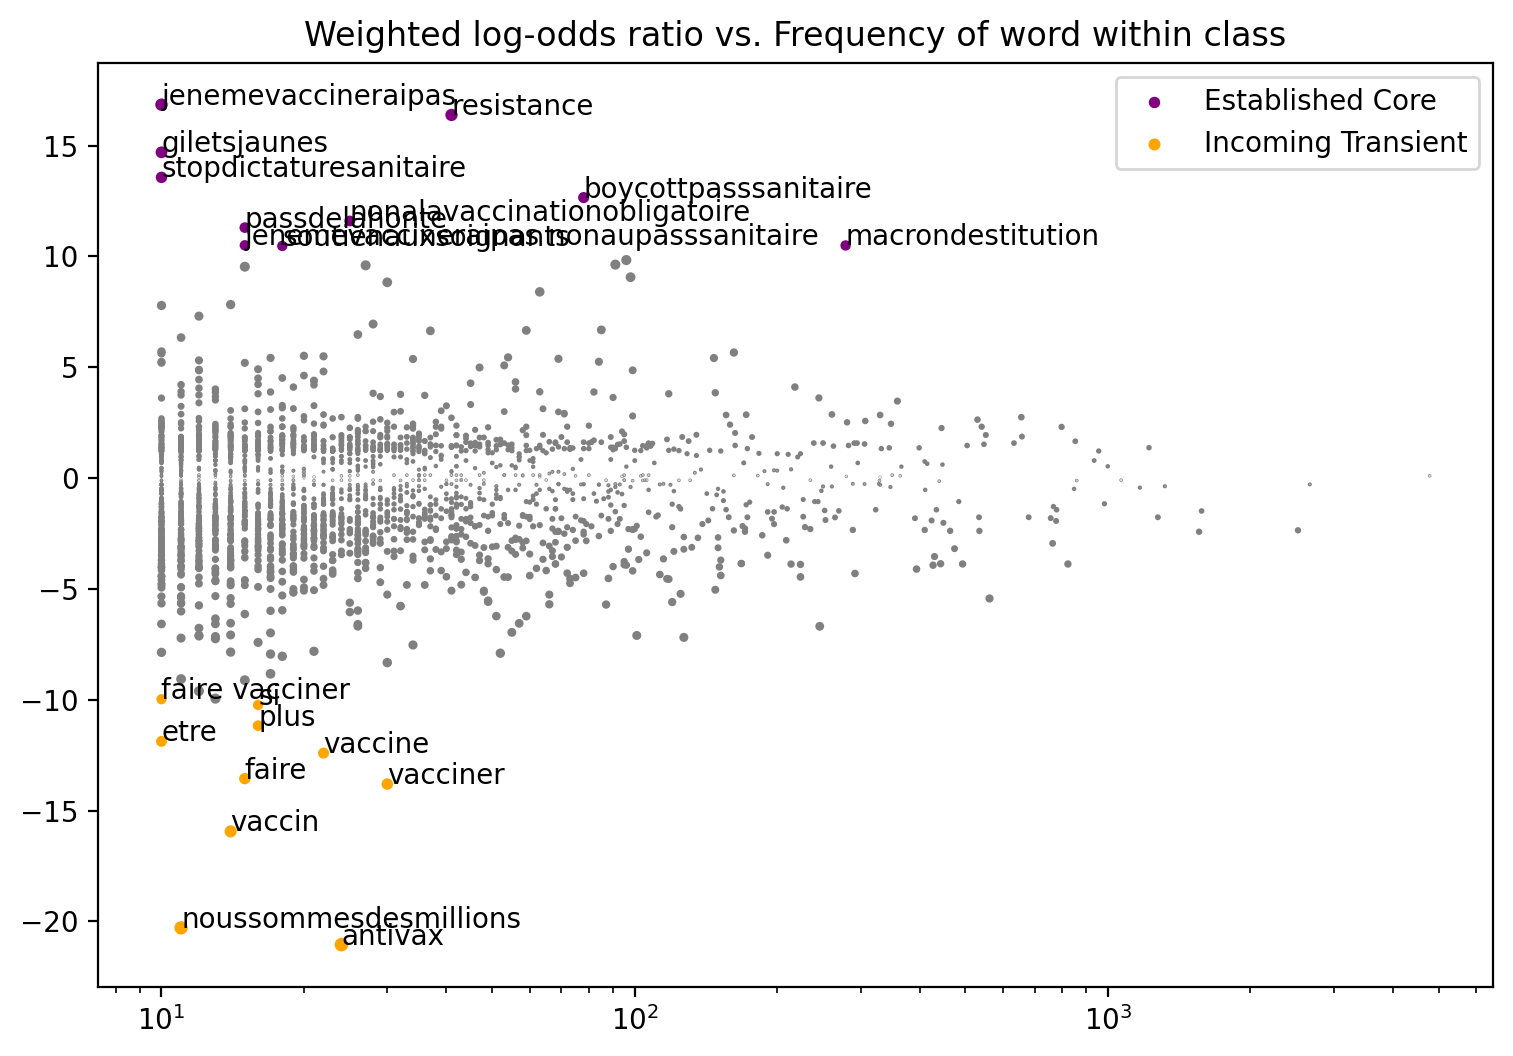

In [ ]:
from convokit import FightingWords

# Initialize the FightingWords object
fw = FightingWords()

# Fit the model to the combined corpus, comparing the groups
fw.fit(combined_corpus, class1_func=lambda utt: utt.meta['group'] == 'Established Core',
       class2_func=lambda utt: utt.meta['group'] == 'Incoming Transient')

# Summarize the results
df_summary = fw.summarize(combined_corpus, plot=True, class1_name='Established Core', class2_name='Incoming Transient')

In [ ]:
df_summary.head(20)

,z-score,class
ngram,,
antivax,-21.050183,Incoming Transient
noussommesdesmillions,-20.291165,Incoming Transient
vaccin,-15.940609,Incoming Transient
vacciner,-13.805811,Incoming Transient
faire,-13.558287,Incoming Transient
vaccine,-12.409089,Incoming Transient
etre,-11.880653,Incoming Transient
plus,-11.172163,Incoming Transient
si,-10.238471,Incoming Transient


In [ ]:
df_summary.tail(20)

,z-score,class
ngram,,
vaccinobligatoire,7.304738,Established Core
nazi,7.785099,Established Core
nonalavaccinationobligatoire nonaupasssanitaire,7.825463,Established Core
noussommesdesmillions jenemevaccineraipas,8.399222,Established Core
giletsjaunes dictature,8.830401,Established Core
veran,9.061362,Established Core
dictaturesanitaire giletsjaunes,9.534209,Established Core
regime,9.596674,Established Core
boycott,9.627868,Established Core


Initializing default CountVectorizer with ngram_range (1, 3)... Done.
class1_func returned 6103 valid corpus components. class2_func returned 6925 valid corpus components.
Vocab size is 3359
Comparing language...
ngram zscores computed.


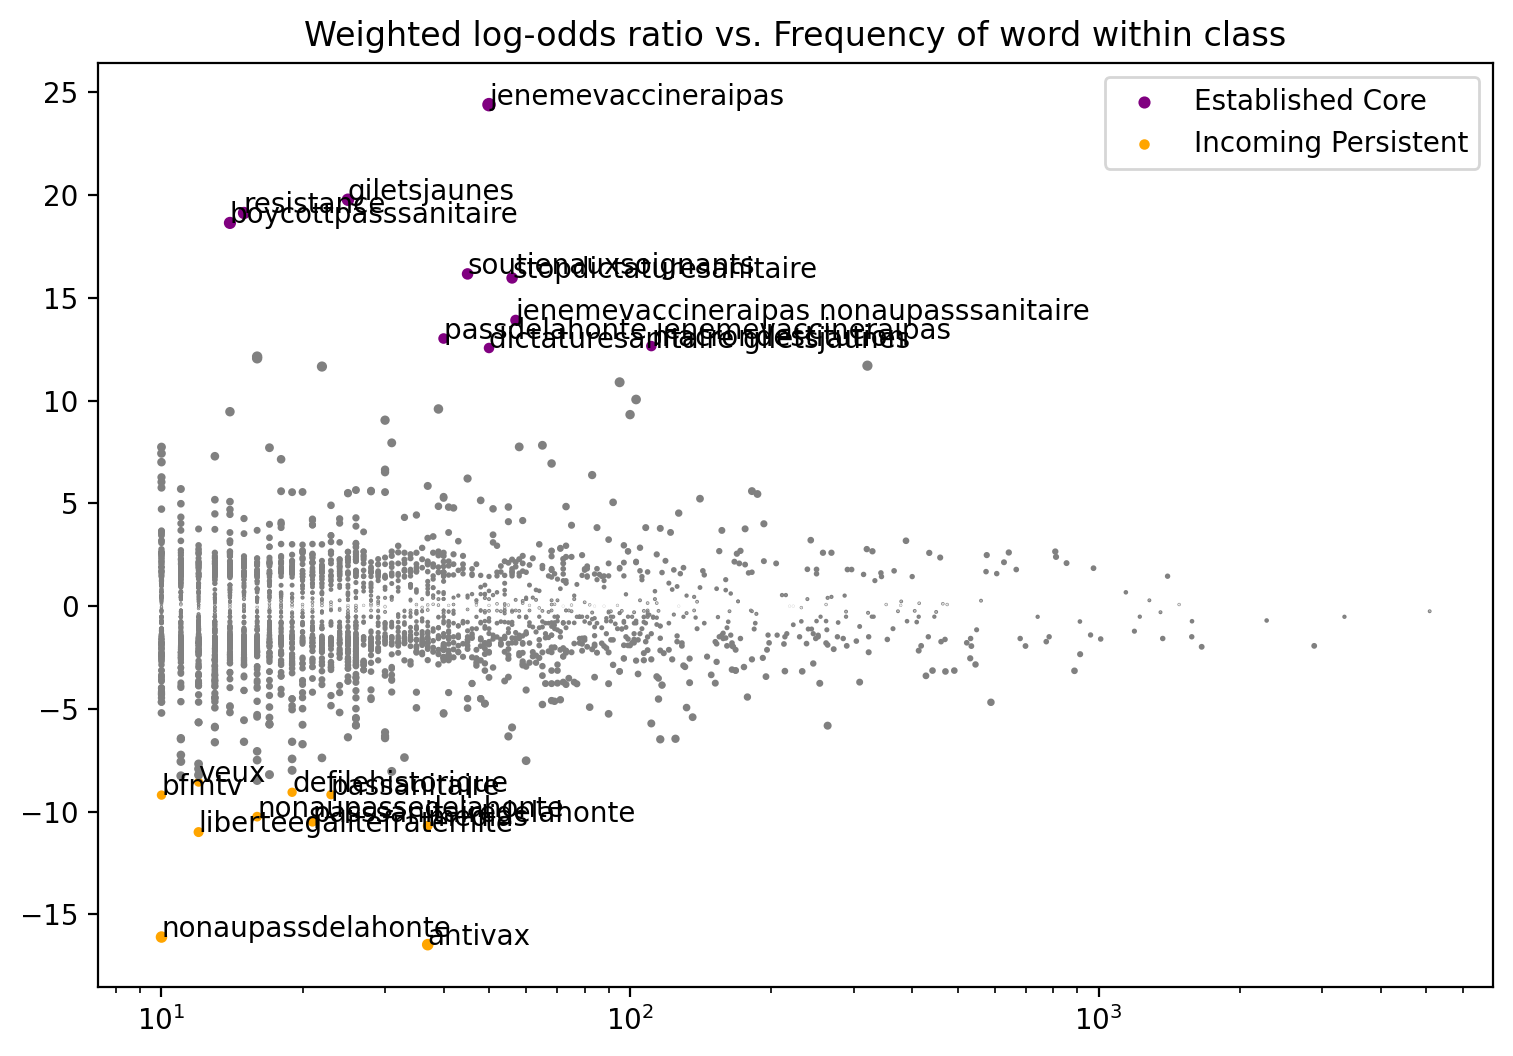

In [ ]:
# Initialize the FightingWords object
fw = FightingWords()

# Fit the model to the combined corpus, comparing the groups
fw.fit(combined_corpus, class1_func=lambda utt: utt.meta['group'] == 'Established Core',
       class2_func=lambda utt: utt.meta['group'] == 'Incoming Persistent')

# Summarize the results
df_summary_2 = fw.summarize(combined_corpus, plot=True, class1_name='Established Core', class2_name='Incoming Persistent')

In [ ]:
df.head()

,author_id,created_at,retweet_count,reply_count,like_count,quote_count,lang,tweet,tweet_clean0,new_labels,labels,week,nostop_tweet
0,1221863565541494787,2020-12-01 00:35:08+00:00,0,0,1,0,fr,Les #GiletsJaunes de banlieue ont sentis avant...,Les #GiletsJaunes de banlieue ont sentis avant...,NaN,1,2020-48,GiletsJaunes banlieue sentis avant tout monde ...
1,1314715851908620289,2020-12-01 00:08:07+00:00,0,0,0,0,fr,Le ministre de la santé belge a admis que la f...,Le ministre de la santé belge a admis que la f...,NaN,1,2020-48,ministre santé belge a admis fermeture petitsc...
2,800457506203963392,2020-12-01 00:07:20+00:00,0,0,0,0,fr,💥#DictatureSanitaire #MortsEhpadsGVT #Confinem...,💥#DictatureSanitaire #MortsEhpadsGVT #Confinem...,NaN,1,2020-48,DictatureSanitaire MortsEhpadsGVT EmmanuelMacr...
3,1306909430764707840,2020-12-01 00:06:06+00:00,0,0,2,0,fr,"Il a parfaitement raison, on y va pas, on y es...","Il a parfaitement raison, on y va pas, on y es...",NaN,1,2020-48,a parfaitement raison va déjà trump sait Pland...
4,193392354,2020-12-01 01:41:03+00:00,0,0,2,0,fr,J'ai donné aux Entrepreneurs en Action du Québ...,J'ai donné aux Entrepreneurs en Action du Québ...,NaN,1,2020-48,donné Entrepreneurs Action Québec manifester o...


In [ ]:
#This is for the paper. It checks if a token has been used more in a hashtag than alone. If more than 80% of the time used in a hashtag I will add the hashtag in the paper.
# Token to check
token = 'faire'

# Initialize counts
count_with_hashtag = 0
count_without_hashtag = 0

# Iterate through each tweet and count occurrences
for tweet in df['tweet_clean0'][df["week"] == "2021-28"]:
    words = tweet.split()
    for word in words:
      if token in word:
        if word[0] == '#':
          count_with_hashtag += 1
        else:
          count_without_hashtag += 1

# Calculate total occurrences
total_occurrences = count_with_hashtag + count_without_hashtag

# Calculate percentage of hashtag usage
percentage_with_hashtag = (count_with_hashtag / total_occurrences * 100) if total_occurrences > 0 else 0

# Display the results
print(f"Occurrences with hashtag (1): {count_with_hashtag}")
print(f"Occurrences without hashtag (0): {count_without_hashtag}")
print(f"Percentage of hashtag usage (1s): {percentage_with_hashtag:.2f}%")

Occurrences with hashtag (1): 3
Occurrences without hashtag (0): 2119
Percentage of hashtag usage (1s): 0.14%


In [ ]:
df_summary_2.head(20)

,z-score,class
ngram,,
antivax,-16.472449,Incoming Persistent
nonaupassdelahonte,-16.102198,Incoming Persistent
liberteegalitefraternite,-10.995526,Incoming Persistent
medias,-10.686927,Incoming Persistent
passsanitairedelahonte,-10.491782,Incoming Persistent
nonaupassedelahonte,-10.245364,Incoming Persistent
bfmtv,-9.196516,Incoming Persistent
passanitaire,-9.176176,Incoming Persistent
defilehistorique,-9.059225,Incoming Persistent


In [ ]:
df_summary_2.tail(20)

,z-score,class
ngram,,
nonaupasssanitaire,9.043834,Established Core
boycott noussommesdesmillions,9.314176,Established Core
jenemevaccineraipas nonalavaccinationobligatoire,9.456237,Established Core
nonalavaccinationobligatoire nonaupasssanitaire,9.589390,Established Core
giletsjaunes dictature,10.050519,Established Core
nonaupasssanitaire vaccinobligatoire,10.889344,Established Core
noussommesdesmillions jenemevaccineraipas,11.653305,Established Core
veran,11.695930,Established Core
boycott,12.053213,Established Core


Initializing default CountVectorizer with ngram_range (1, 3)... Done.
class1_func returned 6925 valid corpus components. class2_func returned 4771 valid corpus components.
Vocab size is 2780
Comparing language...
ngram zscores computed.


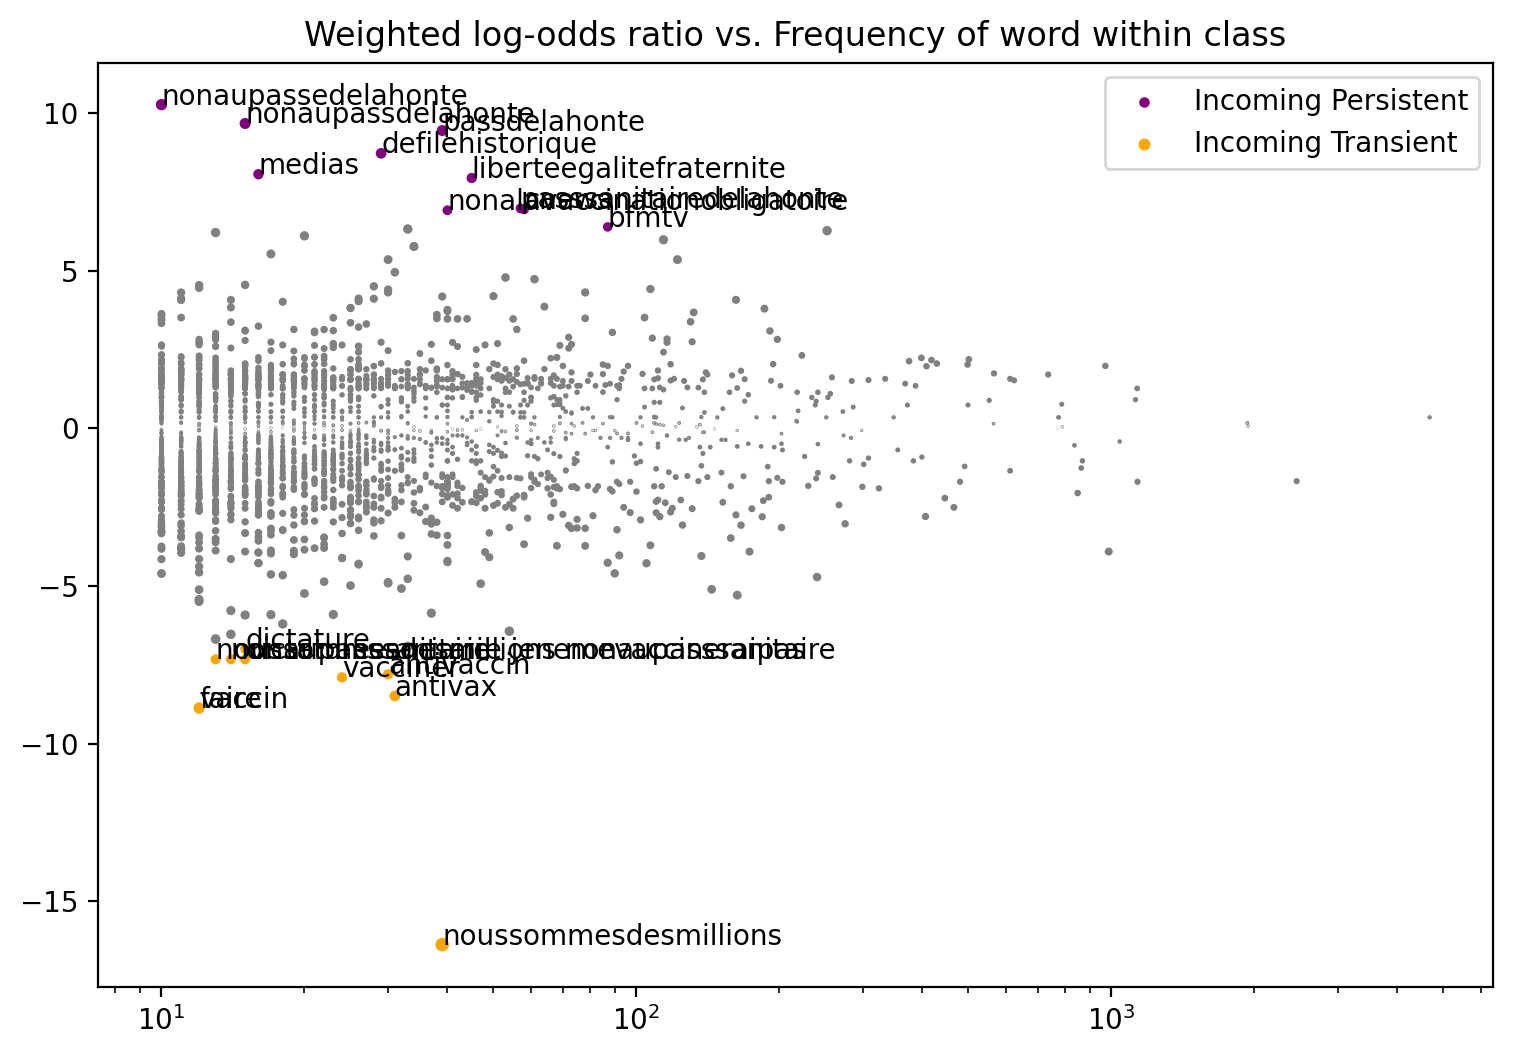

In [ ]:
# Initialize the FightingWords object
fw = FightingWords()

# Fit the model to the combined corpus, comparing the groups
fw.fit(combined_corpus, class1_func=lambda utt: utt.meta['group'] == 'Incoming Persistent',
       class2_func=lambda utt: utt.meta['group'] == 'Incoming Transient')

# Summarize the results
df_summary_3 = fw.summarize(combined_corpus, plot=True, class1_name='Incoming Persistent', class2_name='Incoming Transient')

In [ ]:
df_summary_3.head(20)

,z-score,class
ngram,,
noussommesdesmillions,-16.381595,Incoming Transient
faire,-8.887620,Incoming Transient
vaccin,-8.863336,Incoming Transient
antivax,-8.492229,Incoming Transient
vacciner,-7.902169,Incoming Transient
antivaccin,-7.804287,Incoming Transient
noussommesdesmillions nonaupasssanitaire,-7.329474,Incoming Transient
dictaturesanitaire,-7.329147,Incoming Transient
nonaupasssanitaire jenemevaccineraipas,-7.326924,Incoming Transient


In [ ]:
df_summary_3.tail(20)

,z-score,class
ngram,,
paris,4.951407,Incoming Persistent
selon,5.352472,Incoming Persistent
nonauvaccinobligatoire,5.352526,Incoming Persistent
nonaupassedelahonte nonauvaccinobligatoire,5.532947,Incoming Persistent
minorite,5.768580,Incoming Persistent
noussommesdesmillions passdelahonte,5.982508,Incoming Persistent
macrondictateur,6.107246,Incoming Persistent
rue,6.210314,Incoming Persistent
passanitaire,6.270182,Incoming Persistent
